In [80]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [81]:
from network import *

## Import der Netzwerk-Komponenten
Hier werden die Bausteine aus deinem minimalen `network`-Framework geladen:
- `Dataset`, `DataLoader`: Datenhaltung und Mini-Batch-Erzeugung.
- `Model`: Sequenzieller Container, der Layers verkettet.
- `LinearLayer`, `ReLU`: Affine Schicht und Aktivierungsfunktion.
- `MSELoss`: Mittlerer quadratischer Fehler für Training/Validierung.
- `AdamWOptimizer`: Optimierer (Adam mit entkoppeltem Weight Decay).

Diese Komponenten bilden die gesamte Trainings-/Validierungspipeline ohne externe Deep-Learning-Frameworks.

In [82]:
from pathlib import Path
import pandas as pd
import numpy as np

# Lädt MONK-{problem_id} aus lokalen Dateien in monk+s+problems/
DATA_DIR = Path("monk+s+problems")
assert DATA_DIR.exists(), f"Could not find {DATA_DIR.resolve()}"

def load_monk_local(problem_id: int):
    """
    Load MONK-{problem_id} train/test from local files.
    Returns one-hot encoded numpy arrays aligned by train columns.
    """
    train_path = DATA_DIR / f"monks-{problem_id}.train"
    test_path  = DATA_DIR / f"monks-{problem_id}.test"
    assert train_path.exists() and test_path.exists(), "Missing train/test files."

    # File format: class a1 a2 a3 a4 a5 a6 id (space-separated)
    colnames = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "id"]
    train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=colnames, engine="python")
    test_df  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=colnames, engine="python")

    X_train_df = train_df[["a1","a2","a3","a4","a5","a6"]].astype("category")
    y_train_df = train_df[["class"]].astype(np.float32)

    X_test_df  = test_df[["a1","a2","a3","a4","a5","a6"]].astype("category")
    y_test_df  = test_df[["class"]].astype(np.float32)

    # One-hot encode; align test columns to train columns
    X_train_oh = pd.get_dummies(X_train_df)
    X_test_oh  = pd.get_dummies(X_test_df).reindex(columns=X_train_oh.columns, fill_value=0)

    X_train = X_train_oh.astype(np.float32).to_numpy()
    X_test  = X_test_oh.astype(np.float32).to_numpy()

    y_train = y_train_df.to_numpy().reshape(-1, 1)
    y_test  = y_test_df.to_numpy().reshape(-1, 1)

    return X_train, y_train, X_test, y_test, X_train_oh.columns.tolist()

# Choose which MONK problem to run (1, 2, or 3)
PROBLEM_ID = 1

X_train_full, y_train_full, X_test, y_test, feature_names = load_monk_local(PROBLEM_ID)

print(f"MONK-{PROBLEM_ID}: X_train={X_train_full.shape}, y_train={y_train_full.shape}, X_test={X_test.shape}, y_test={y_test.shape}, input_dim={X_train_full.shape[1]}")
print("First 5 feature columns:", feature_names[:5])
print("Train class balance:", float(y_train_full.mean()), "(fraction of class=1)")
print("Test  class balance:",  float(y_test.mean()),       "(fraction of class=1)")

MONK-1: X_train=(124, 17), y_train=(124, 1), X_test=(432, 17), y_test=(432, 1), input_dim=17
First 5 feature columns: ['a1_1', 'a1_2', 'a1_3', 'a2_1', 'a2_2']
Train class balance: 0.5 (fraction of class=1)
Test  class balance: 0.5 (fraction of class=1)


## Laden des MONK-Datensatzes
Diese Zelle lädt das MONK-Datenset aus der UCI-Repository und zeigt Metadaten/Variablen.
- `fetch_ucirepo(id=70)`: Lädt MONK's Problems.
- `X`, `y`: Features und Targets als DataFrames.
- Ausgabe: Metadaten und Variablenübersicht zur Orientierung.

In [83]:
# (Optional) Preview: show first rows from the local raw files
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("monk+s+problems")
colnames = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "id"]
train_path = DATA_DIR / f"monks-{PROBLEM_ID}.train"
test_path  = DATA_DIR / f"monks-{PROBLEM_ID}.test"

train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=colnames, engine="python")
test_df  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=colnames, engine="python")

print("Train head:")
display(train_df.head())
print("Test head:")
display(test_df.head())

Train head:


,class,a1,a2,a3,a4,a5,a6,id
0,1,1,1,1,1,3,1,data_5
1,1,1,1,1,1,3,2,data_6
2,1,1,1,1,3,2,1,data_19
3,1,1,1,1,3,3,2,data_22
4,1,1,1,2,1,2,1,data_27


Test head:


,class,a1,a2,a3,a4,a5,a6,id
0,1,1,1,1,1,1,1,data_1
1,1,1,1,1,1,1,2,data_2
2,1,1,1,1,1,2,1,data_3
3,1,1,1,1,1,2,2,data_4
4,1,1,1,1,1,3,1,data_5


## Erste Sichtung und Vorbereitung
- Importiere Pandas/NumPy.
- Lade `monk` erneut und weise `X_df`/`y_df` explizit zu.
- Ausgabe: `head()`-Sichten zur Plausibilitätsprüfung der rohen Daten.

In [84]:
# One-hot encoding is already done by load_monk_local above.
# Here we just expose X/y names expected by later cells.
X = X_train_full
y = y_train_full

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (124, 17)
y shape: (124, 1)


## One-Hot-Encoding und NumPy-Konvertierung
- `pd.get_dummies(X_df)`: One-Hot-Encoding aller kategorialen Feature-Spalten (a1..a6).
- Konvertiere Features zu `float32` NumPy-Array: `X`.
- Targets: `y_df['class']` zu `float32` und als Spaltenvektor `(N, 1)` reshaped.
- Ausgaben zeigen erwartete Shapes (typisch `(N, 17)` für X, `(N, 1)` für y).
Hinweis: Einheitliche Datentypen und Shapes sind wichtig für die Mini-Batch-Verarbeitung.

In [85]:
n_total = X.shape[0]
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

X_train, y_train = X[:n_train],               y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val],  y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],         y[n_train+n_val:]

## Train/Val/Test-Split
- Zerlege die Daten in 80% Training, 10% Validierung, 10% Test.
- Behalte die Reihenfolge (kein Shuffle hier), da K-Fold später eigenes Shuffling nutzt.
- Liefert `X_train`, `X_val`, `X_test` (und zugehörige `y_*`).
Hinweis: Für reproduzierbare Vergleiche sind feste Splits hilfreich; K-Fold ergänzt später robuste Auswertung.

In [86]:
from network.dataset import Dataset
from network.dataloader import DataLoader

train_dataset = Dataset(X_train, y_train)
val_dataset   = Dataset(X_val,   y_val)
test_dataset  = Dataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

## DataLoader-Setup
- Erzeuge `Dataset`-Objekte für die drei Splits.
- Initialisiere `DataLoader` mit Batchgröße 32; Training mit Shuffle, Val/Test ohne Shuffle.
- Zweck: Effiziente Mini-Batch-Verarbeitung und konsistente Evaluierung.

In [87]:
input_dim = X_train.shape[1]   # should be 17
print("input_dim:", input_dim)

model = Model(
    LinearLayer(input_dim, 8),
    ReLU(),
    LinearLayer(8, 16),
    ReLU(),
    LinearLayer(16, 1),
)

loss_fn = MSELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.003, weight_decay=0.001)

input_dim: 17


## Modellaufbau und Optimierer
- Modell: `Linear(input_dim, 16) → ReLU → Linear(16, 8) → ReLU → Linear(8, 1)`.
- Loss: `MSELoss` (voll reduziert).
- Optimizer: `AdamWOptimizer` (`learning_rate=0.001`, `weight_decay=0.01`).

Hinweise:
- Die Ausgabe ist linear; für Klassifikations-Accuracy wird später ein dynamischer Threshold (Median der Predictions) verwendet.
- Shapes müssen konsistent bleiben: z. B. `(Batch, 17) → ... → (Batch, 1)`.

In [88]:
num_epochs = 150
train_loss_history = []
val_loss_history   = []
val_acc_history    = []

for epoch in range(num_epochs):
    # ----- Training -----
    train_losses = []
    for x_batch, y_batch in train_loader:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)

        grad = loss_fn.backward()
        model.backward(grad)
        optimizer.step()

        train_losses.append(loss)

    # ----- Validation -----
    val_losses = []
    correct = 0
    total = 0

    for x_batch, y_batch in val_loader:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        val_losses.append(loss)

        # threshold 0.5 for class 0/1
        preds = (y_pred > 0.5).astype(np.float32)
        correct += (preds == y_batch).sum()
        total   += y_batch.size

    mean_train = float(np.mean(train_losses))
    mean_val   = float(np.mean(val_losses))
    val_acc    = float(correct / total)

    train_loss_history.append(mean_train)
    val_loss_history.append(mean_val)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {mean_train:.4f} | "
          f"Val Loss: {mean_val:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 001 | Train Loss: 0.5951 | Val Loss: 0.7138 | Val Acc: 0.2500
Epoch 002 | Train Loss: 0.3758 | Val Loss: 0.5665 | Val Acc: 0.3333
Epoch 003 | Train Loss: 0.3360 | Val Loss: 0.4936 | Val Acc: 0.4167
Epoch 004 | Train Loss: 0.2468 | Val Loss: 0.4685 | Val Acc: 0.4167
Epoch 005 | Train Loss: 0.2251 | Val Loss: 0.4673 | Val Acc: 0.3333
Epoch 006 | Train Loss: 0.2131 | Val Loss: 0.4772 | Val Acc: 0.3333
Epoch 007 | Train Loss: 0.2063 | Val Loss: 0.4861 | Val Acc: 0.3333
Epoch 008 | Train Loss: 0.2583 | Val Loss: 0.4830 | Val Acc: 0.3333
Epoch 009 | Train Loss: 0.2120 | Val Loss: 0.4734 | Val Acc: 0.4167
Epoch 010 | Train Loss: 0.1905 | Val Loss: 0.4576 | Val Acc: 0.4167
Epoch 011 | Train Loss: 0.1960 | Val Loss: 0.4402 | Val Acc: 0.4167
Epoch 012 | Train Loss: 0.1931 | Val Loss: 0.4231 | Val Acc: 0.4167
Epoch 013 | Train Loss: 0.1456 | Val Loss: 0.4115 | Val Acc: 0.4167
Epoch 014 | Train Loss: 0.1591 | Val Loss: 0.4004 | Val Acc: 0.5000
Epoch 015 | Train Loss: 0.1824 | Val Loss: 0.390

Epoch 020 | Train Loss: 0.1719 | Val Loss: 0.3926 | Val Acc: 0.5000
Epoch 021 | Train Loss: 0.1650 | Val Loss: 0.3908 | Val Acc: 0.5000
Epoch 022 | Train Loss: 0.1728 | Val Loss: 0.3826 | Val Acc: 0.5000
Epoch 023 | Train Loss: 0.1432 | Val Loss: 0.3735 | Val Acc: 0.5833
Epoch 024 | Train Loss: 0.1193 | Val Loss: 0.3575 | Val Acc: 0.6667
Epoch 025 | Train Loss: 0.1645 | Val Loss: 0.3453 | Val Acc: 0.6667
Epoch 026 | Train Loss: 0.1570 | Val Loss: 0.3356 | Val Acc: 0.6667
Epoch 027 | Train Loss: 0.1329 | Val Loss: 0.3274 | Val Acc: 0.6667
Epoch 028 | Train Loss: 0.1422 | Val Loss: 0.3216 | Val Acc: 0.6667
Epoch 029 | Train Loss: 0.1297 | Val Loss: 0.3202 | Val Acc: 0.6667
Epoch 030 | Train Loss: 0.1438 | Val Loss: 0.3260 | Val Acc: 0.6667
Epoch 031 | Train Loss: 0.1326 | Val Loss: 0.3306 | Val Acc: 0.5833
Epoch 032 | Train Loss: 0.1189 | Val Loss: 0.3253 | Val Acc: 0.6667
Epoch 033 | Train Loss: 0.1389 | Val Loss: 0.3146 | Val Acc: 0.6667
Epoch 034 | Train Loss: 0.1174 | Val Loss: 0.308

## Training und Validierung pro Epoche
Ablauf je Epoche:
- Training: Vorwärtslauf → MSE-Loss → Backward (Loss-Gradient) → Parameter-Update (AdamW).
- Validierung: Vorwärtslauf auf Val-Splits, Sammeln der Val-Losse.
- Accuracy: Binarisierung der Vorhersagen mit Schwelle 0.5 (hier als einfache Heuristik) und Vergleich mit `y_batch`.

Hinweise:
- Mit linearer Ausgabe ist der feste Threshold 0.5 nicht immer optimal. In späteren Zellen wird ein Median-Threshold genutzt, der robuster gegenüber Skalenverschiebungen ist.
- `train_loss_history`, `val_loss_history`, `val_acc_history` speichern die Metriken je Epoche für Plots.

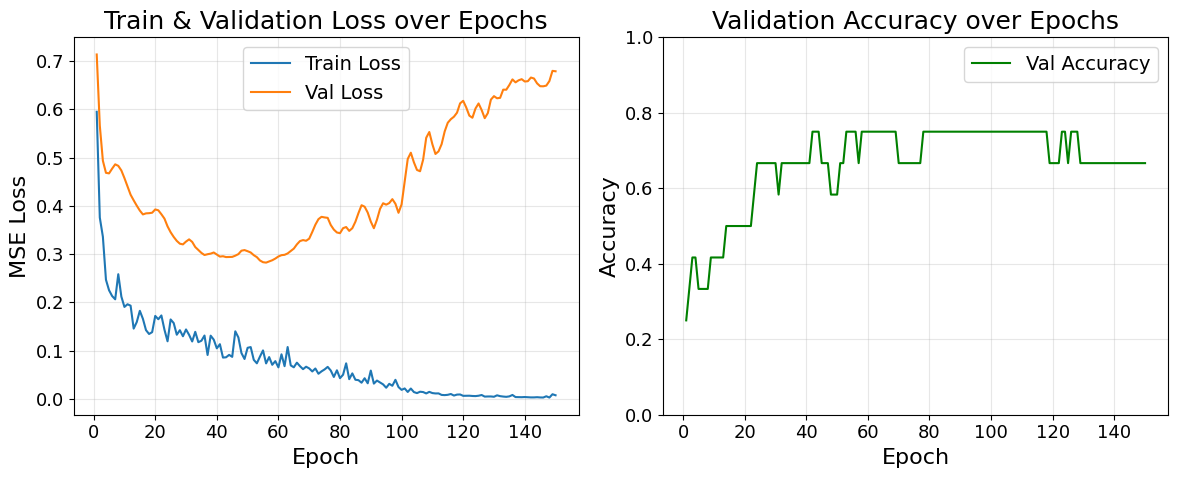

In [89]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# ------------------ LOSS ------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train & Validation Loss over Epochs")
plt.legend()
plt.grid(alpha=0.3)

# ------------------ ACCURACY ------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_history, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Visualisierung: Loss- und Accuracy-Kurven
- Erstellt zwei Subplots:
  - Train-/Val-Loss über die Epochen (MSE).
  - Val-Accuracy über die Epochen (Skala 0–1).
- Dient zur Diagnose von Lernverhalten, Over-/Underfitting und Stabilität.

In [90]:
# Nested Cross-Validation + Grid Search (nur network + NumPy/Pandas)
import numpy as np
from copy import deepcopy

# Hilfsfunktionen basierend auf vorhandenen network-Klassen
def build_model(input_dim, hidden_sizes):
    layers = []
    in_dim = input_dim
    for h in hidden_sizes:
        layers.append(LinearLayer(in_dim, h))
        layers.append(ReLU())
        in_dim = h
    layers.append(LinearLayer(in_dim, 1))
    return Model(*layers)

def make_loader(x, y, batch_size, shuffle):
    ds = Dataset(x, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def train_one_config(X_tr, y_tr, X_val, y_val, config, seed=42):
    np.random.seed(seed)
    model = build_model(X_tr.shape[1], config['hidden_sizes'])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=config['learning_rate'], weight_decay=config['weight_decay'])
    train_loader = make_loader(X_tr, y_tr, batch_size=config['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val, y_val, batch_size=config['batch_size'], shuffle=False)
    for _ in range(config['num_epochs']):
        for xb, yb in train_loader:
            y_pred = model.forward(xb)
            loss = loss_fn.forward(y_pred, yb)
            grad = loss_fn.backward()
            model.backward(grad)
            optimizer.step()
    # Val loss
    val_losses = []
    for xb, yb in val_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        val_losses.append(l)
    return float(np.mean(val_losses)), model

def evaluate_test(model, X_te, y_te, batch_size):
    test_loader = make_loader(X_te, y_te, batch_size=batch_size, shuffle=False)
    loss_fn = MSELoss()
    losses = []
    correct = 0
    total = 0
    for xb, yb in test_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        losses.append(l)
        thr = float(np.median(yp))
        pred_bin = (yp >= thr).astype(np.float32)
        correct += (pred_bin == yb).sum()
        total   += yb.size
    return float(np.mean(losses)), float(correct/total)

# K-Fold Splitter (NumPy, ohne sklearn)
def kfold_indices(n_samples, k, seed=42, shuffle=True):
    rng = np.random.default_rng(seed)
    indices = np.arange(n_samples)
    if shuffle:
        rng.shuffle(indices)
    folds = np.array_split(indices, k)
    return folds

def get_train_val_from_folds(folds, val_fold_idx):
    val_idx = folds[val_fold_idx]
    train_idx = np.concatenate([folds[i] for i in range(len(folds)) if i != val_fold_idx])
    return train_idx, val_idx

# Grid Definition (klein halten wegen Laufzeit)
param_grid = {
    'hidden_sizes': [ (16, 8), (32, 16) ],
    'learning_rate': [ 0.001, 0.003 ],
    'weight_decay': [ 0.0, 0.001 ],
    'batch_size': [ 32 ],
    'num_epochs': [ 80 ]
}
grid_configs = []
for hs in param_grid['hidden_sizes']:
    for lr in param_grid['learning_rate']:
        for wd in param_grid['weight_decay']:
            for bs in param_grid['batch_size']:
                for ne in param_grid['num_epochs']:
                    grid_configs.append({
                        'hidden_sizes': hs,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'batch_size': bs,
                        'num_epochs': ne,
                    })

# Nested CV Parameter
k_outer = 5
k_inner = 3
print(f"Nested CV startet: outer k={k_outer}, inner k={k_inner}, grid size={len(grid_configs)}")
print(f"Erwartete Trainingsläufe: {k_outer} * {len(grid_configs)} * {k_inner} = {k_outer*len(grid_configs)*k_inner}")

# Daten aus vorherigen Zellen: X, y (NumPy)
N = X.shape[0]
outer_folds = kfold_indices(N, k_outer, seed=123, shuffle=True)

outer_results = []
for ofi in range(k_outer):
    # Outer split: hold-out Test = dieser Fold
    test_idx = outer_folds[ofi]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != ofi])
    X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
    X_test,     y_test     = X[test_idx],     y[test_idx]

    # Inner CV für Grid Search
    inner_folds = kfold_indices(X_trainval.shape[0], k_inner, seed=321+ofi, shuffle=True)
    cfg_to_score = []
    for cfg in grid_configs:
        inner_losses = []
        for ifi in range(k_inner):
            val_i_idx = inner_folds[ifi]
            train_i_idx = np.concatenate([inner_folds[j] for j in range(k_inner) if j != ifi])
            X_tr, y_tr = X_trainval[train_i_idx], y_trainval[train_i_idx]
            X_val_i, y_val_i = X_trainval[val_i_idx], y_trainval[val_i_idx]
            val_loss_i, _ = train_one_config(X_tr, y_tr, X_val_i, y_val_i, cfg, seed=42+ifi)
            inner_losses.append(val_loss_i)
        cfg_to_score.append((cfg, float(np.mean(inner_losses))))
    # beste Konfiguration nach mittlerem inner Val-Loss
    cfg_to_score.sort(key=lambda x: x[1])
    best_cfg, best_inner_loss = cfg_to_score[0]
    # Retrain auf vollständigem Train+Val des Outer-Folds
    # Hier splitten wir noch ein kleines Holdout für Monitoring (optional)
    # oder trainieren direkt und evaluieren auf Outer-Test
    # Wir trainieren direkt auf trainval und testen auf test.
    # Für Konsistenz nutzen wir denselben Ablauf wie oben:
    # Train auf trainval, keine Val nötig.
    # Einfach: nehme train_one_config mit Val=X_test (wird ignoriert in Training)
    final_val_loss, best_model = train_one_config(X_trainval, y_trainval, X_test, y_test, best_cfg, seed=999)
    test_loss, test_acc = evaluate_test(best_model, X_test, y_test, batch_size=best_cfg['batch_size'])
    print(f"[Outer {ofi+1}/{k_outer}] Best cfg={best_cfg} | inner mean ValLoss={best_inner_loss:.4f} | TestLoss={test_loss:.4f} | TestAcc={test_acc:.4f}")
    outer_results.append({
        'outer_fold': ofi,
        'best_cfg': best_cfg,
        'inner_mean_val_loss': best_inner_loss,
        'test_loss': test_loss,
        'test_acc': test_acc,
    })

# Zusammenfassung
mean_test_loss = float(np.mean([r['test_loss'] for r in outer_results]))
mean_test_acc  = float(np.mean([r['test_acc']  for r in outer_results]))
print("\n=== Gesamtergebnisse über Outer-Folds ===")
print(f"Mean Test Loss: {mean_test_loss:.4f}")
print(f"Mean Test Acc : {mean_test_acc:.4f}")

Nested CV startet: outer k=5, inner k=3, grid size=8
Erwartete Trainingsläufe: 5 * 8 * 3 = 120
[Outer 1/5] Best cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 80} | inner mean ValLoss=0.1419 | TestLoss=0.1451 | TestAcc=0.8000
[Outer 1/5] Best cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 80} | inner mean ValLoss=0.1419 | TestLoss=0.1451 | TestAcc=0.8000
[Outer 2/5] Best cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | inner mean ValLoss=0.1579 | TestLoss=0.2558 | TestAcc=0.6800
[Outer 2/5] Best cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | inner mean ValLoss=0.1579 | TestLoss=0.2558 | TestAcc=0.6800
[Outer 3/5] Best cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | 

## Nested Cross-Validation mit Grid Search
Dieser Abschnitt führt eine verschachtelte Cross-Validation (Nested CV) durch, um Hyperparameter robust zu wählen und anschließend die Generalisierungsleistung zu messen.

- Outer K-Folds: Jeder Fold dient einmal als unabhängiges Test-Set. Die übrigen Daten bilden das Train+Val-Set.
- Inner K-Folds: Für jede Hyperparameter-Kombination wird eine K-fache Validierung innerhalb des Train+Val-Sets durchgeführt. Der mittlere Validierungs-Loss über die inneren Folds dient als Gütemaß.
- Auswahl: Die Konfiguration mit dem kleinsten mittleren inneren Val-Loss wird pro Outer-Fold gewählt.
- Retrain + Test: Mit der gewählten Konfiguration wird auf dem gesamten Train+Val des Outer-Folds trainiert und auf dem gehaltenen Test-Set evaluiert (Loss + Accuracy).

Wichtige Punkte:
- Es werden ausschließlich die vorhandenen `network`-Bausteine verwendet (`Model`, `LinearLayer`, `ReLU`, `MSELoss`, `AdamWOptimizer`, `Dataset`, `DataLoader`).
- Für die Accuracy wird ein datengetriebener Schwellenwert verwendet (Median der Predictions je Auswertung), da die letzte Schicht linear ist und keine Sigmoid-Aktivierung nutzt.
- Die erwartete Anzahl Trainingsläufe ist `k_outer * grid_size * k_inner`, hier bewusst klein gehalten, um Laufzeit zu kontrollieren.

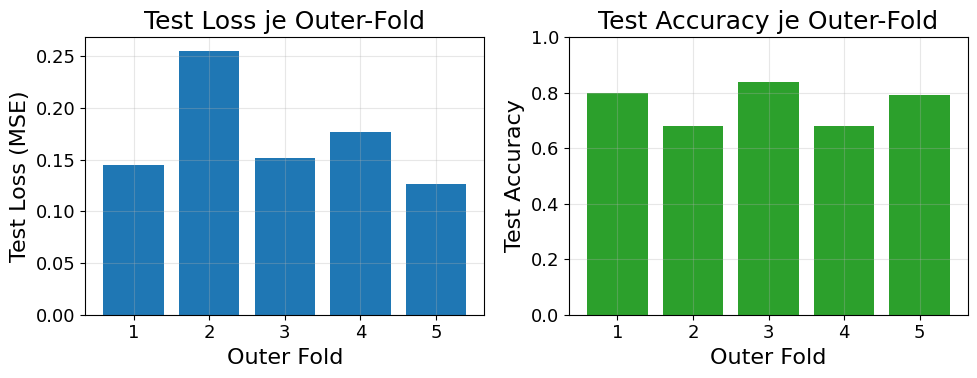

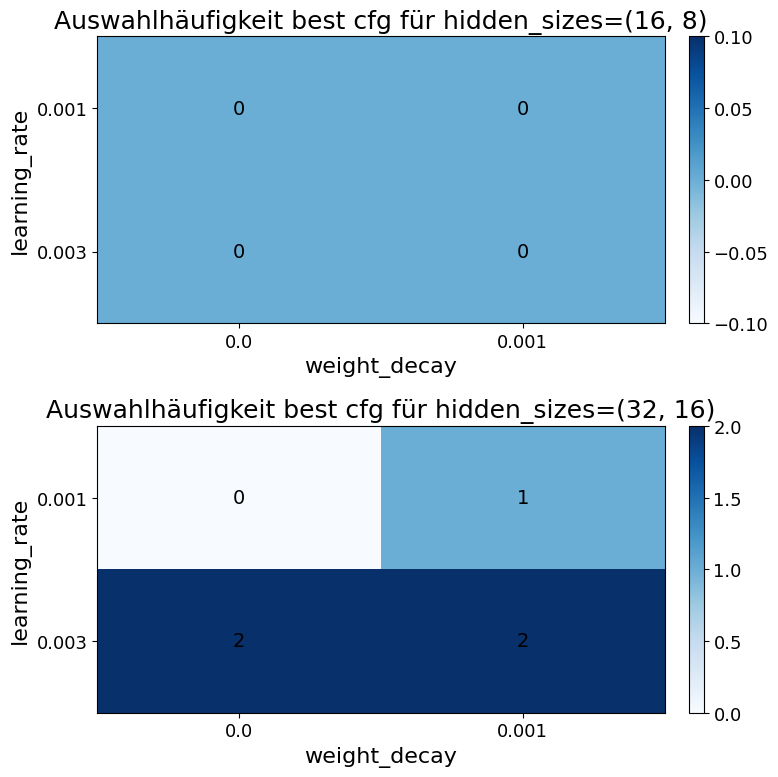


Beste Konfiguration je Outer-Fold:
Fold 1: cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 80} | TestLoss=0.1451 | TestAcc=0.8000
Fold 2: cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | TestLoss=0.2558 | TestAcc=0.6800
Fold 3: cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | TestLoss=0.1520 | TestAcc=0.8400
Fold 4: cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 80} | TestLoss=0.1771 | TestAcc=0.6800
Fold 5: cfg={'hidden_sizes': (32, 16), 'learning_rate': 0.003, 'weight_decay': 0.001, 'batch_size': 32, 'num_epochs': 80} | TestLoss=0.1261 | TestAcc=0.7917


In [91]:
# Visualisierung der Grid-Resultate und Outer-Fold-Ergebnisse
import numpy as np
import matplotlib.pyplot as plt

# Erwartet: Variablen aus der Nested-CV-Zelle
# - grid_configs: Liste aller getesteten Konfigurationen
# - outer_results: Liste mit Einträgen {'outer_fold', 'best_cfg', 'inner_mean_val_loss', 'test_loss', 'test_acc'}

# 1) Balkendiagramm: Test-Loss und Test-Accuracy je Outer-Fold
fold_ids   = [r['outer_fold']+1 for r in outer_results]
test_losses = [r['test_loss'] for r in outer_results]
test_accs   = [r['test_acc']  for r in outer_results]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(fold_ids, test_losses, color='tab:blue')
plt.xlabel('Outer Fold')
plt.ylabel('Test Loss (MSE)')
plt.title('Test Loss je Outer-Fold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(fold_ids, test_accs, color='tab:green')
plt.xlabel('Outer Fold')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy je Outer-Fold')
plt.ylim(0.0, 1.0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Auswahlhäufigkeit der besten Konfigurationen: Heatmaps pro hidden_sizes
# Wir stellen die Häufigkeit dar, mit der (learning_rate, weight_decay)
# pro hidden_sizes als beste Konfiguration gewählt wurde.
# Das ist eine kompakte graphische Repräsentation des Grids via Auswahlfrequenz.

# Extrahiere eindeutige Werte
hidden_sizes_list = sorted(list({cfg['hidden_sizes'] for cfg in grid_configs}))
lr_list           = sorted(list({cfg['learning_rate'] for cfg in grid_configs}))
wd_list           = sorted(list({cfg['weight_decay'] for cfg in grid_configs}))

# Zähle Best-Selections
from collections import defaultdict
freq = defaultdict(int)
for r in outer_results:
    cfg = r['best_cfg']
    key = (tuple(cfg['hidden_sizes']), cfg['learning_rate'], cfg['weight_decay'])
    freq[key] += 1

# Erzeuge Heatmaps: Zeilen=learning_rate, Spalten=weight_decay; pro hidden_sizes ein Subplot
n_rows = len(hidden_sizes_list)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 4*n_rows), squeeze=False)

for i, hs in enumerate(hidden_sizes_list):
    mat = np.zeros((len(lr_list), len(wd_list)), dtype=float)
    for r_i, lr in enumerate(lr_list):
        for c_i, wd in enumerate(wd_list):
            mat[r_i, c_i] = freq.get((hs, lr, wd), 0)
    ax = axes[i, 0]
    im = ax.imshow(mat, cmap='Blues', aspect='auto')
    ax.set_title(f'Auswahlhäufigkeit best cfg für hidden_sizes={hs}')
    ax.set_xticks(np.arange(len(wd_list)))
    ax.set_xticklabels([str(wd) for wd in wd_list])
    ax.set_xlabel('weight_decay')
    ax.set_yticks(np.arange(len(lr_list)))
    ax.set_yticklabels([str(lr) for lr in lr_list])
    ax.set_ylabel('learning_rate')
    for r_i in range(len(lr_list)):
        for c_i in range(len(wd_list)):
            ax.text(c_i, r_i, f"{int(mat[r_i, c_i])}", ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# 3) Tabelle der besten Konfigurationen je Outer-Fold (als Textausgabe)
print('\nBeste Konfiguration je Outer-Fold:')
for r in outer_results:
    print(f"Fold {r['outer_fold']+1}: cfg={r['best_cfg']} | TestLoss={r['test_loss']:.4f} | TestAcc={r['test_acc']:.4f}")

## Visualisierung der Grid- und Fold-Ergebnisse
Diese Zelle fasst die Resultate der Nested-CV grafisch zusammen.

- Balkendiagramme: Zeigen pro Outer-Fold den Test-Loss (MSE) und die Test-Accuracy. Damit wird die Varianz über verschiedene Test-Splits sichtbar.
- Heatmaps: Visualisieren die Auswahlhäufigkeit der besten Konfigurationen für jedes `hidden_sizes`-Setting. Achsen sind `learning_rate` (Zeilen) und `weight_decay` (Spalten); der Zellenwert gibt an, wie oft die Kombination als beste Konfiguration gewählt wurde.
- Tabelle: Listet pro Outer-Fold die gefundene beste Konfiguration und deren Testkennzahlen als Text aus.

Hinweise:
- Die Heatmaps sind eine kompakte Repräsentation des Parameter-Grids; sie zeigen, welche Bereiche des Grids häufiger vorn liegen.
- Mit größeren Grids können weitere Dimensionen (z. B. `batch_size`, `num_epochs`) separat visualisiert werden (z. B. zusätzliche Subplots).

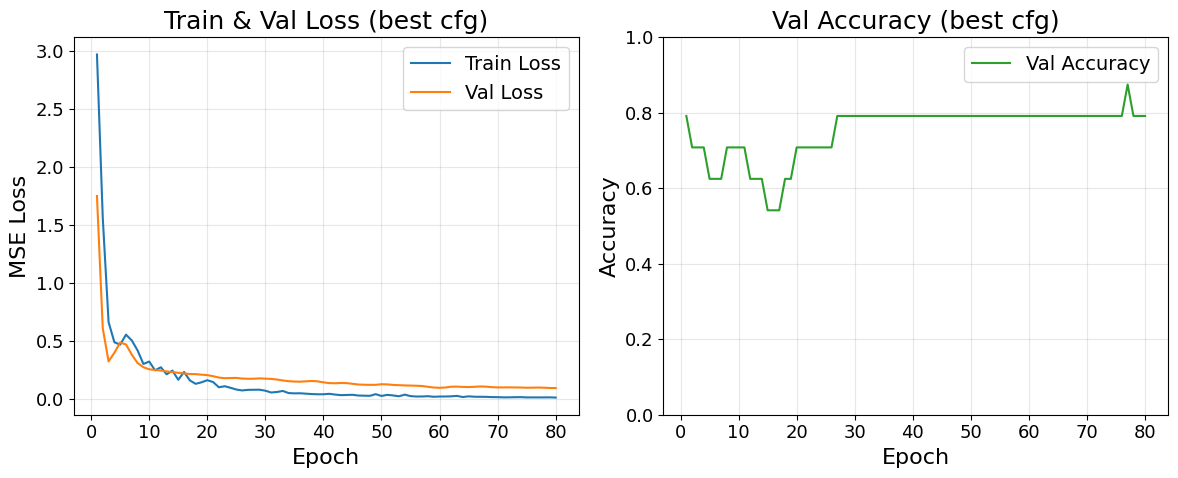

In [92]:
# Accuracy-Kurve über Epochen für die beste Konfiguration (aus Nested CV)
import numpy as np
import matplotlib.pyplot as plt

# Wir trainieren die best_cfg erneut und zeichnen Val-Accuracy je Epoche auf.
# Nutzung ausschließlich der vorhandenen network-Klassen.

def train_with_acc_history(X_tr, y_tr, X_val, y_val, cfg, seed=123):
    np.random.seed(seed)
    model = build_model(X_tr.shape[1], cfg['hidden_sizes'])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
    train_loader = make_loader(X_tr, y_tr, batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val, y_val, batch_size=cfg['batch_size'], shuffle=False)
    train_loss_hist = []
    val_loss_hist   = []
    val_acc_hist    = []
    for _ in range(cfg['num_epochs']):
        # Train
        train_losses = []
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
            train_losses.append(l)
        # Validate
        val_losses = []
        preds_all = []
        ys_all    = []
        for xb, yb in val_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            val_losses.append(l)
            preds_all.append(yp)
            ys_all.append(yb)
        mean_train = float(np.mean(train_losses))
        mean_val   = float(np.mean(val_losses))
        p = np.concatenate(preds_all, axis=0)
        y_true = np.concatenate(ys_all, axis=0)
        thr = float(np.median(p))
        pred_bin = (p >= thr).astype(np.float32)
        acc = float((pred_bin == y_true).sum() / y_true.size)
        train_loss_hist.append(mean_train)
        val_loss_hist.append(mean_val)
        val_acc_hist.append(acc)
    return {
        'model': model,
        'train_loss_history': train_loss_hist,
        'val_loss_history': val_loss_hist,
        'val_acc_history': val_acc_hist,
    }

# Safeguard: Falls best_cfg nicht existiert (Zelle nicht ausgeführt)
try:
    hist_run = train_with_acc_history(
        X_trainval, y_trainval, X_test, y_test, best_cfg, seed=2025
    )
    epochs = np.arange(1, len(hist_run['train_loss_history']) + 1)
    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist_run['train_loss_history'], label='Train Loss')
    plt.plot(epochs, hist_run['val_loss_history'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train & Val Loss (best cfg)')
    plt.legend()
    plt.grid(alpha=0.3)
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist_run['val_acc_history'], color='tab:green', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Val Accuracy (best cfg)')
    plt.ylim(0.0, 1.0)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
except NameError:
    print('Bitte zuerst die Nested-CV-Zelle ausführen, damit best_cfg/X_trainval/y_trainval/X_test/y_test verfügbar sind.')

## Accuracy-Kurve für die beste Konfiguration
Diese Zelle trainiert die aus der Nested CV ermittelte `best_cfg` erneut und protokolliert pro Epoche:
- Train-Loss (MSE)
- Val-Loss (MSE)
- Val-Accuracy (binär, mit Median-Threshold über die Val-Predictions der jeweiligen Epoche)

Warum Median-Threshold?
- Da der letzte Layer linear ist (ohne Sigmoid), liegen die Roh-Predictions nicht notwendigerweise in [0, 1]. Der Median als dynamischer Schwellenwert teilt die Vorhersagen pro Epoche robust in zwei Klassen, ohne zusätzliche Aktivierungsfunktion.

Was der Plot zeigt:
- Linke Seite: Train/Val-Loss über die Epochen – Lernfortschritt und potenzielles Over-/Underfitting.
- Rechte Seite: Val-Accuracy – Klassifikationsgüte über die Zeit.

Falls `best_cfg` oder die benötigten Datensplits (`X_trainval`, `y_trainval`, `X_test`, `y_test`) nicht verfügbar sind, bitte zuerst die Nested-CV-Zelle ausführen.

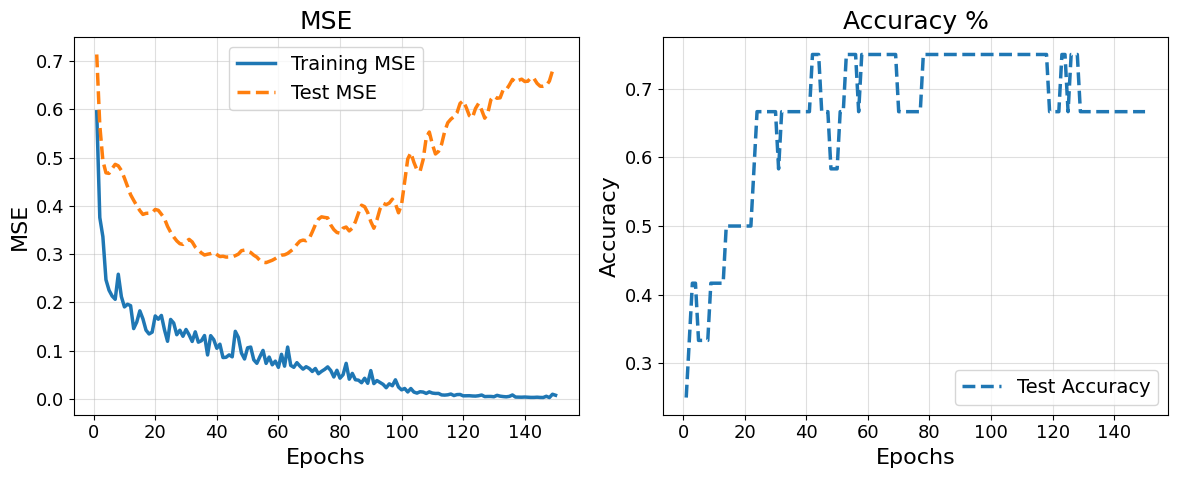

In [93]:
# Plots für MONK-Datensätze mit Guidelines (BW, große Fonts)
import numpy as np
import matplotlib.pyplot as plt

# Hilfsfunktion: Genauigkeit über Epochen (Median-Threshold)
def accuracy_median_threshold(y_true_epoch_list, y_pred_epoch_list):
    accs = []
    for t, p in zip(y_true_epoch_list, y_pred_epoch_list):
        thr = np.median(p)
        y_hat = (p >= thr).astype(np.float32)
        correct = (y_hat == t).astype(np.float32)
        accs.append(float(np.mean(correct)))
    return np.array(accs)

# Plot-Funktion mit Guidelines (BW lesbar, große Fonts)
def plot_curves_guideline(train_mse, val_mse, train_acc=None, val_acc=None, title_prefix='MONK'):
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'legend.fontsize': 14,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
    })
    epochs = np.arange(1, len(train_mse)+1)
    fig = plt.figure(figsize=(12,5))
    # MSE links
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, train_mse, linestyle='-', linewidth=2.5, label='Training MSE')
    ax1.plot(epochs, val_mse,   linestyle='--', linewidth=2.5, label='Test MSE')
    ax1.set_title('MSE')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE')
    ax1.grid(alpha=0.4)
    ax1.legend(loc='best')
    # Accuracy rechts (auch wenn nur val_acc vorhanden)
    ax2 = fig.add_subplot(1,2,2)
    lines_plotted = False
    if train_acc is not None:
        ax2.plot(epochs, train_acc, linestyle='-',  linewidth=2.5, label='Training Accuracy')
        lines_plotted = True
    if val_acc is not None:
        ax2.plot(epochs, val_acc,   linestyle='--', linewidth=2.5, label='Test Accuracy')
        lines_plotted = True
    ax2.set_title('Accuracy %')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(alpha=0.4)
    if lines_plotted:
        ax2.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Automatischer Fallback: nutze vorhandene Historien aus den Trainingszellen
# train_loss_history, val_loss_history, val_acc_history
try:
    train_mse_fallback = np.array(train_loss_history)
    val_mse_fallback   = np.array(val_loss_history)
    val_acc_fallback   = np.array(val_acc_history) if 'val_acc_history' in globals() else None
    # Wenn nur val_acc existiert, zeichnen wir zumindest diese
    plot_curves_guideline(train_mse_fallback, val_mse_fallback, None, val_acc_fallback, title_prefix='MONK')
except Exception as e:
    print('Plot-Fallback fehlgeschlagen:', e)
    print('Bitte stelle sicher, dass train_loss_history/val_loss_history (und optional val_acc_history) definiert sind.')

# Optional: Vollversion für MONK1/2/3 mit detaillierten Listen, falls vorhanden
try:
    # MONK 1
    train_mse_1 = np.array(train_mse_monks[0])
    val_mse_1   = np.array(val_mse_monks[0])
    train_acc_1 = accuracy_median_threshold(train_trues_monks[0], train_preds_monks[0])
    val_acc_1   = accuracy_median_threshold(val_trues_monks[0],   val_preds_monks[0])
    plot_curves_guideline(train_mse_1, val_mse_1, train_acc_1, val_acc_1, title_prefix='MONK 1')
    # MONK 2
    train_mse_2 = np.array(train_mse_monks[1])
    val_mse_2   = np.array(val_mse_monks[1])
    train_acc_2 = accuracy_median_threshold(train_trues_monks[1], train_preds_monks[1])
    val_acc_2   = accuracy_median_threshold(val_trues_monks[1],   val_preds_monks[1])
    plot_curves_guideline(train_mse_2, val_mse_2, train_acc_2, val_acc_2, title_prefix='MONK 2')
    # MONK 3
    train_mse_3 = np.array(train_mse_monks[2])
    val_mse_3   = np.array(val_mse_monks[2])
    train_acc_3 = accuracy_median_threshold(train_trues_monks[2], train_preds_monks[2])
    val_acc_3   = accuracy_median_threshold(val_trues_monks[2],   val_preds_monks[2])
    plot_curves_guideline(train_mse_3, val_mse_3, train_acc_3, val_acc_3, title_prefix='MONK 3')
except NameError:
    # Wenn die detaillierten MONK-Listen nicht existieren, ist das okay – Fallback oben genügt.
    pass